In [1]:

# ========================== 📦 IMPORT SECTION ==========================
import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

import time
from ast import literal_eval
from typing import List, Dict, Any

import pandas as pd
from dotenv import load_dotenv
from tqdm import tqdm

from ragas.dataset_schema import Sample, EvaluationDataset, SingleTurnSample
from src.tag.src.text2sql_pipeline import generate_sql  # path kamu
from src.tag.evaluation.run_text2sql import run_text2sql_workflow
from src.tag.src.query_executor import execute_text2sql_response
from src.tag.evaluation.eval_metrics import evaluate_retriever  # gunakan retriever-style
from src.tag.database.db_connection import connect_db
from src.tag.database.schema_loader import load_schema




d:\code\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
d:\code\src\tag\src\text2sqlchain_few.py:13: LangChainDeprecationWarning: The class `OllamaEmbeddings` was deprecated in LangChain 0.3.1 and will be removed in 1.0.0. An updated version of the class exists in the :class:`~langchain-ollama package and should be used instead. To use it run `pip install -U :class:`~langchain-ollama` and import as `from :class:`~langchain_ollama import OllamaEmbeddings``.
  embedding_model = OllamaEmbeddings(model="nomic-embed-text")


KeyboardInterrupt: 

In [ ]:
conn = connect_db()
schema = load_schema(conn)

In [ ]:
DATASET_PATH = os.path.join("data", "Dataset Testing Archive 2.xlsx")
df = pd.read_excel(DATASET_PATH)

dataset = []

# Filter for "is_valid" rows first, then sample
valid_df = df[df["is_valid"]]

# Sample 85 rows randomly from the valid_df
# If there are fewer than 85 valid rows, it will take all of them.
sampled_df = valid_df.head(100)

for i, row in sampled_df.iterrows():
    dataset.append({
        "user_input": str(row["user_input"]),
        "reference_contexts": literal_eval(row["reference_contexts_2"])
    })

print(f"Jumlah soal: {len(dataset)}")

Jumlah soal: 100


In [5]:
def save_checkpoint_json(data: Any, filename: str):
    os.makedirs("outputs", exist_ok=True)
    path = os.path.join("outputs", filename)
    with open(path, "w", encoding="utf-8") as f:
        json.dump(data, f, indent=2, ensure_ascii=False)
    print(f"✅ Saved: {filename}")

def retry_until_success(func, *args, max_delay=60, base_delay=5, **kwargs):
    """
    Melakukan retry berulang dengan backoff jika error Claude overload (kode 529).
    """
    delay = base_delay
    while True:
        try:
            return func(*args, **kwargs)
        except Exception as e:
            error_msg = str(e).lower()
            if "overload" in error_msg or "529" in error_msg:
                print(f"⚠️ Claude overload. Menunggu {delay} detik lalu retry...")
                time.sleep(delay)
                delay = min(delay * 2, max_delay)  # backoff maksimal 60 detik
            else:
                print(f"❌ Error bukan overload: {e}")
                raise  # error lain (misal bug prompt) tetap dilempar

def retrieve_contexts_from_text2sql(question: str, shot_mode: str, llm_mode: str) -> list[str]:
    try:
        # 🔁 Retry LLM jika Claude overload
        response = retry_until_success(
            generate_sql,
            schema, question,
            top_k=100,
            shot_mode=shot_mode,
            llm_mode=llm_mode
        )

        rows, columns = execute_text2sql_response(conn, response)
        if not rows:
            return ["data tidak ditemukan"]
        return [" | ".join(map(str, row)) for row in rows]

    except Exception as e:
        print(f"[!] Error executing SQL for question: {question}")
        print(f"[!] Exception: {e}")
        try:
            conn.rollback()
        except Exception as rollback_error:
            print(f"[!] Rollback failed: {rollback_error}")
        return ["sql gagal dieksekusi"]

def run_single_test_case(test_case: Dict[str, Any], resume: bool = False) -> Dict[str, Any]:
    experiment_name = test_case["experiment_name"]
    shot_mode = test_case["shot_mode"]
    llm_mode = test_case["llm_mode"]

    print(f"\n🚀 Mulai eksperimen: {experiment_name} | Mode: {shot_mode} | LLM: {llm_mode}")

    samples = []
    fallback_count = 0
    start_idx = 0

    # ✅ Jika resume diaktifkan, load autosave
    if resume:
        autosave_path = f"outputs/{experiment_name}_autosave.json"
        if os.path.exists(autosave_path):
            print(f"🔁 Melanjutkan dari autosave: {autosave_path}")
            with open(autosave_path, "r", encoding="utf-8") as f:
                saved_data = json.load(f)
            samples = [SingleTurnSample(**s) for s in saved_data]
            start_idx = len(samples)
            print(f"✅ Total soal yang sudah selesai: {start_idx}")
        else:
            print("⚠️ Tidak ditemukan autosave. Mulai dari awal.")

    for idx, item in enumerate(tqdm(dataset[start_idx:], desc=f"Running from {start_idx + 1}")):
        real_idx = start_idx + idx

        q = item["user_input"]
        ref = item["reference_contexts"]
        retrieved = retrieve_contexts_from_text2sql(q, shot_mode=shot_mode, llm_mode=llm_mode)

        if retrieved == ["sql gagal dieksekusi"]:
            fallback_count += 1

        sample = SingleTurnSample(
            question=q,
            reference_contexts=ref,
            retrieved_contexts=retrieved
        )
        samples.append(sample)

        if (real_idx + 1) % 3 == 0:
            save_checkpoint_json(
                [s.model_dump() for s in samples],
                f"{experiment_name}_autosave.json"
            )

    print(f"📌 Total fallback (SQL gagal dieksekusi): {fallback_count} dari {len(samples)} soal")

    save_checkpoint_json(
        [s.model_dump() for s in samples],
        f"{experiment_name}_samples.json"
    )

    eval_dataset = EvaluationDataset(samples)

    try:
        result = evaluate_retriever(eval_dataset, experiment_name=experiment_name)

        save_checkpoint_json(
            result.to_pandas().to_dict(orient="records"),
            f"{experiment_name}_evaluation.json"
        )

        df_result = result.to_pandas()
        print("\n📊 Ringkasan Hasil Evaluasi:")
        display(df_result[["retrieved_contexts", "reference_contexts", "precision", "recall"]])

        return {
            "experiment_name": experiment_name,
            "shot_mode": shot_mode,
            "evaluation_result": result,
            "samples": samples
        }

    except Exception as e:
        print(f"❌ Gagal mengevaluasi: {e}")
        return {
            "experiment_name": experiment_name,
            "shot_mode": shot_mode,
            "evaluation_result": None,
            "samples": samples
        }


In [16]:
from pydantic import BaseModel
from typing import List

class Sample(BaseModel):
    question: str
    retrieved_contexts: List[str]
    reference_contexts: List[str]


In [ ]:
import json

def evaluate_json_file(json_path: str, experiment_name: str):
    with open(json_path, "r", encoding="utf-8") as f:
        raw_data = json.load(f)

    samples = []
    skipped = 0  
    
    for idx, entry in enumerate(raw_data):
        q = entry.get("user_input") or entry.get("question")  # fleksibel
        retrieved = entry.get("retrieved_contexts", [])
        reference = entry.get("reference_contexts", [])

        if not q or not retrieved or not reference:
            skipped += 1
            continue

        try:
            sample = SingleTurnSample(
                question=q,
                retrieved_contexts=retrieved,
                reference_contexts=reference
            )
            samples.append(sample)
        except Exception as e:
            print(f"[!] Gagal parsing sample {idx}: {e}")
            skipped += 1

    if not samples:
        print("❌ Tidak ada sample valid.")
        return

    eval_dataset = EvaluationDataset(samples)
    result = evaluate_retriever(eval_dataset, experiment_name=experiment_name)

    df = result.to_pandas()
    print("\n📊 Ringkasan Precision dan Recall:")
    print(df[["precision", "recall"]].describe())

    return result

NameError: name 'raw_data' is not defined

In [24]:
evaluate_json_file("ollama_zero_samples.json", "exp1")


Evaluating:  48%|████▊     | 97/200 [00:07<00:05, 19.70it/s]Exception raised in Job[144]: ValidationError(1 validation error for SingleTurnSample
reference
  Input should be a valid string [type=string_type, input_value=0, input_type=int]
    For further information visit https://errors.pydantic.dev/2.11/v/string_type)
Exception raised in Job[145]: ValidationError(1 validation error for SingleTurnSample
reference
  Input should be a valid string [type=string_type, input_value=0, input_type=int]
    For further information visit https://errors.pydantic.dev/2.11/v/string_type)
Evaluating: 100%|██████████| 200/200 [00:07<00:00, 26.68it/s]



📊 Ringkasan Precision dan Recall:
       precision     recall
count  99.000000  99.000000
mean    0.054515   0.072391
std     0.212605   0.251031
min     0.000000   0.000000
25%     0.000000   0.000000
50%     0.000000   0.000000
75%     0.000000   0.000000
max     1.000000   1.000000


{'precision': 0.0545, 'recall': 0.0724}

In [ ]:
evaluate_json_file("ollama_few_samples.json", "exp2")


Evaluating:  55%|█████▍    | 109/200 [00:00<00:00, 151.85it/s]Exception raised in Job[144]: ValidationError(1 validation error for SingleTurnSample
reference
  Input should be a valid string [type=string_type, input_value=2, input_type=int]
    For further information visit https://errors.pydantic.dev/2.11/v/string_type)
Exception raised in Job[145]: ValidationError(1 validation error for SingleTurnSample
reference
  Input should be a valid string [type=string_type, input_value=2, input_type=int]
    For further information visit https://errors.pydantic.dev/2.11/v/string_type)
Evaluating:  75%|███████▌  | 150/200 [03:47<01:15,  1.52s/it] 
Exception raised in Job[182]: ValidationError(1 validation error for SingleTurnSample
reference
  Input should be a valid string [type=string_type, input_value=76, input_type=int]
    For further information visit https://errors.pydantic.dev/2.11/v/string_type)
Exception raised in Job[183]: ValidationError(1 validation error for SingleTurnSample
refer

In [ ]:
test_cases = [
    {
        "experiment_name": "gemini_zero",
        "shot_mode": "zero-shot",
        "llm_mode": "gemini"
    },
    {
        "experiment_name": "gemini_few",
        "shot_mode": "few-shot",
        "llm_mode": "gemini"
    },
    {
        "experiment_name": "ollama_zero",
        "shot_mode": "zero-shot",
        "llm_mode": "ollama"
    },
    {
        "experiment_name": "ollama_few",
        "shot_mode": "few-shot",
        "llm_mode": "ollama"
    }
]


In [50]:
result_zero = run_single_test_case(test_cases[0])

🚀 Menjalankan eksperimen: gemini_zero (mode: zero-shot) (llm: gemini)


Evaluating: 100%|██████████| 20/20 [00:02<00:00,  9.78it/s] 



📊 Ringkasan Hasil Evaluasi:


,retrieved_contexts,reference_contexts,precision,recall
0,"[202103010100000 | 202003005100000 | 1, 201403...",[{'title': 'Peraturan Menteri Komunikasi dan I...,0.000000,0.0
1,[data tidak ditemukan],[(1) Setiap Orang dengan sengaja dan tanpa hak...,0.000000,0.0
2,[data tidak ditemukan],"[{'number': '1'}, {'number': '3'}, {'number': ...",0.000000,0.0
3,[Penyelenggara Sistem Elektronik Lingkup Priva...,[Dalam Peraturan Menteri ini yang dimaksud den...,0.000000,0.0
4,[20 | (1) Pelaksanaan Audit TIK oleh Lembaga P...,"[(1) LPP, LPS, dan LPK jasa Penyiaran televisi...",0.086957,1.0
5,[Internet Exchange Point | Internet Exchange P...,[Dalam Peraturan Menteri ini yang dimaksud den...,0.000000,0.0
6,[202103005100000 | Peraturan Menteri Komunikas...,[(1) Penyelenggara Jasa Telekomunikasi wajib m...,0.000000,0.0
7,"[Pasal 100 PP Nomor 71 Tahun 2019 | 38, Pasal ...","[{'name': 'Pasal 100 PP Nomor 71 Tahun 2019', ...",0.600000,0.6
8,[data tidak ditemukan],[Setiap orang yang melakukan panggilan ke Pusa...,0.000000,0.0
9,[data tidak ditemukan],[(1) Persentase TKDN untuk belanja modal (cape...,0.000000,0.0


In [51]:
df_result_zero = result_zero['evaluation_result'].to_pandas()

avg_precision = df_result_zero['precision'].mean()
avg_recall = df_result_zero['recall'].mean()

print(f"Rata-rata Precision: {avg_precision:.4f}")
print(f"Rata-rata Recall: {avg_recall:.4f}")

Rata-rata Precision: 0.0687
Rata-rata Recall: 0.1600


In [37]:
result_few = run_single_test_case(test_cases[1])

🚀 Menjalankan eksperimen: gemini_few (mode: few-shot)


Evaluating: 100%|██████████| 20/20 [00:02<00:00,  9.60it/s] 



📊 Ringkasan Hasil Evaluasi:


,retrieved_contexts,reference_contexts,precision,recall
0,[diubah_oleh | Peraturan Menteri Komunikasi da...,[{'title': 'Peraturan Menteri Komunikasi dan I...,0.865385,0.150442
1,[data tidak ditemukan],[(1) Setiap Orang dengan sengaja dan tanpa hak...,0.000000,0.000000
2,[data tidak ditemukan],"[{'number': '1'}, {'number': '3'}, {'number': ...",0.000000,0.000000
3,[PSE Lingkup Privat User Generated Content | P...,[Dalam Peraturan Menteri ini yang dimaksud den...,0.000000,0.000000
4,[1 | Dalam Peraturan Menteri ini yang dimaksud...,"[(1) LPP, LPS, dan LPK jasa Penyiaran televisi...",0.222222,1.000000
5,[Internet Exchange Point | Internet Exchange P...,[Dalam Peraturan Menteri ini yang dimaksud den...,0.000000,0.000000
6,[79 | (1) Penyelenggara Jasa Telekomunikasi wa...,[(1) Penyelenggara Jasa Telekomunikasi wajib m...,1.000000,1.000000
7,"[Pasal 100 PP Nomor 71 Tahun 2019 | 38, Pasal ...","[{'name': 'Pasal 100 PP Nomor 71 Tahun 2019', ...",0.600000,0.600000
8,[24 | Pelanggaran terhadap ketentuan sebagaima...,[Setiap orang yang melakukan panggilan ke Pusa...,1.000000,0.500000
9,[1 | Dalam Peraturan Menteri ini yang dimaksud...,[(1) Persentase TKDN untuk belanja modal (cape...,0.500000,0.750000


In [38]:
df_result_few = result_few['evaluation_result'].to_pandas()

avg_precision = df_result_few['precision'].mean()
avg_recall = df_result_few['recall'].mean()

print(f"Rata-rata Precision: {avg_precision:.4f}")
print(f"Rata-rata Recall: {avg_recall:.4f}")

Rata-rata Precision: 0.4188
Rata-rata Recall: 0.4000


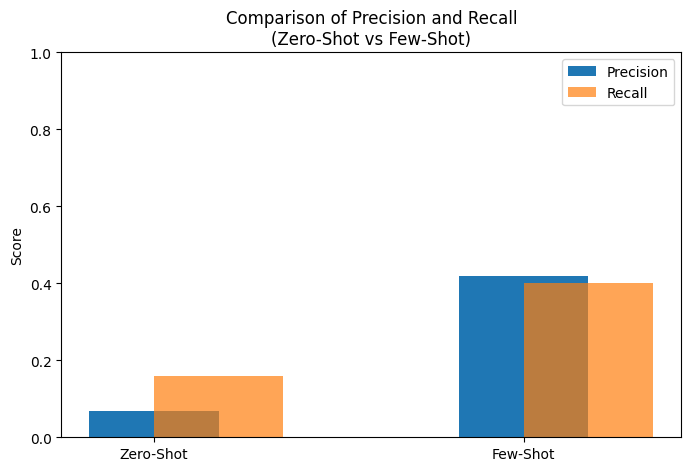

Zero-Shot: Precision=0.0687, Recall=0.1600
Few-Shot:  Precision=0.4188, Recall=0.4000


In [52]:
import matplotlib.pyplot as plt

# Extract average precision and recall for both experiments
avg_precision_zero = df_result_zero['precision'].mean()
avg_recall_zero = df_result_zero['recall'].mean()
avg_precision_few = df_result_few['precision'].mean()
avg_recall_few = df_result_few['recall'].mean()

# Prepare data for plotting
labels = ['Zero-Shot', 'Few-Shot']
precision_scores = [avg_precision_zero, avg_precision_few]
recall_scores = [avg_recall_zero, avg_recall_few]

x = range(len(labels))

plt.figure(figsize=(8, 5))
plt.bar(x, precision_scores, width=0.35, label='Precision', align='center')
plt.bar(x, recall_scores, width=0.35, label='Recall', align='edge', alpha=0.7)
plt.xticks(x, labels)
plt.ylabel('Score')
plt.title('Comparison of Precision and Recall\n(Zero-Shot vs Few-Shot)')
plt.ylim(0, 1)
plt.legend()
plt.show()

print(f"Zero-Shot: Precision={avg_precision_zero:.4f}, Recall={avg_recall_zero:.4f}")
print(f"Few-Shot:  Precision={avg_precision_few:.4f}, Recall={avg_recall_few:.4f}")

# **Tidak dipakai**

In [4]:
def retrieve_contexts_from_text2sql_zero(question: str) -> list[str]:
    try:
        response = generate_sql(schema, question, top_k=100, shot_mode="zero-shot", llm_mode="gemini")
        rows, columns = execute_text2sql_response(conn, response)
        if not rows:
            return ["data tidak ditemukan"]
        return [" | ".join(map(str, row)) for row in rows]
    except Exception as e:
        print(f"[!] Error: {question} → {e}")
        return []


In [4]:
def retrieve_contexts_from_text2sql_few(question: str) -> list[str]:
    try:
        response = generate_sql(schema, question, top_k=100, shot_mode="few-shot", llm_mode="gemini")
        rows, columns = execute_text2sql_response(conn, response)
        if not rows:
            return ["data tidak ditemukan"]
        return [" | ".join(map(str, row)) for row in rows]
    except Exception as e:
        print(f"[!] Error: {question} → {e}")
        return []


In [5]:
samples = []

for item in tqdm(dataset, desc="Menjalankan Text2SQL dan Eksekusi"):
    q = item["user_input"]
    ref = item["reference_contexts"]
    ret = retrieve_contexts_from_text2sql_zero(q)

    sample = SingleTurnSample(
        question=q,
        reference_contexts=ref,
        retrieved_contexts=ret
    )
    samples.append(sample)

evaluation_dataset = EvaluationDataset(samples)


Menjalankan Text2SQL dan Eksekusi:   0%|          | 0/15 [00:00<?, ?it/s]d:\code\src\tag\src\text2sql_pipeline.py:18: LangChainDeprecationWarning: The class `LLMChain` was deprecated in LangChain 0.1.17 and will be removed in 1.0. Use :meth:`~RunnableSequence, e.g., `prompt | llm`` instead.
  chain = LLMChain(llm=llm, prompt=prompt)
d:\code\src\tag\src\text2sql_pipeline.py:26: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~invoke` instead.
  return chain.run(inputs).strip()
Menjalankan Text2SQL dan Eksekusi: 100%|██████████| 15/15 [00:32<00:00,  2.17s/it]


In [6]:
result = evaluate_retriever(evaluation_dataset, experiment_name="tag_retriever_v1")
df_result_zero = result.to_pandas()
df_result_zero


Evaluating: 100%|██████████| 30/30 [00:01<00:00, 19.51it/s]


,retrieved_contexts,reference_contexts,precision,recall
0,[data tidak ditemukan],[(1) Persentase TKDN untuk belanja modal (cape...,0.000000,0.0
1,[data tidak ditemukan],[Lembaga Penyiaran Asing dilarang didirikan di...,0.000000,0.0
2,[202403006500400 | 4 | Seleksi pengguna Pita F...,[(1) Pelaksanaan Diklat REOR sebagaimana dimak...,0.000000,0.0
3,[Jaringan Dokumentasi dan Informasi Hukum Keme...,[Dalam Peraturan Menteri ini yang dimaksud den...,0.000000,0.0
4,[22 | (1) Registrar Nama Domain Selain Instans...,[Registri Nama Domain dan Registrar Nama Domai...,0.000000,0.0
5,[data tidak ditemukan],[Informasi tarif retail layanan jelajah (roami...,0.000000,0.0
6,[201503017500100 | 1 | Pembaca kartu cerdas ni...,[Pembaca kartu cerdas nirkontak (Contactless S...,1.000000,1.0
7,[6 | (1) Laporan sebagaimana dimaksud dalam Pa...,[(1) Laporan sebagaimana dimaksud dalam Pasal ...,0.000000,0.0
8,[data tidak ditemukan],[(1) Permohonan Nomor PI dapat dilakukan oleh ...,0.000000,0.0
9,[data tidak ditemukan],[Setiap alat dan perangkat telekomunikasi jara...,0.000000,0.0


In [7]:
avg_precision = df_result_zero['precision'].mean()
avg_recall = df_result_zero['recall'].mean()

print(f"Rata-rata Precision: {avg_precision:.4f}")
print(f"Rata-rata Recall: {avg_recall:.4f}")

Rata-rata Precision: 0.0793
Rata-rata Recall: 0.1667


In [5]:
import time
from tqdm import tqdm

samples = []

for i, item in enumerate(tqdm(dataset, desc="Menjalankan Text2SQL dan Eksekusi")):
    q = item["user_input"]
    ref = item["reference_contexts"]

    try:
        ret = retrieve_contexts_from_text2sql_few(q)
    except Exception as e:
        print(f"[!] Error executing SQL for question: {q}")
        print(f"    → {e}")
        
        # Lakukan rollback untuk mengakhiri transaction yang gagal
        try:
            conn.rollback()
            print("[✓] Transaction rollback executed.")
        except Exception as rollback_err:
            print(f"[X] Failed to rollback transaction: {rollback_err}")
        
        ret = []  # Tetap buat list kosong agar tidak error saat membuat sample

    sample = SingleTurnSample(
        question=q,
        reference_contexts=ref,
        retrieved_contexts=ret
    )
    samples.append(sample)

    # Pause setiap 10 pertanyaan
    if (i + 1) % 5 == 0:
        print(f"[i] Processed {i+1} samples. Sleeping for 15 seconds...")
        time.sleep(15)

evaluation_dataset_few = EvaluationDataset(samples)


Menjalankan Text2SQL dan Eksekusi:   0%|          | 0/55 [00:00<?, ?it/s]d:\code\src\tag\src\text2sql_pipeline.py:22: LangChainDeprecationWarning: The class `LLMChain` was deprecated in LangChain 0.1.17 and will be removed in 1.0. Use :meth:`~RunnableSequence, e.g., `prompt | llm`` instead.
  chain = LLMChain(llm=llm, prompt=prompt)
d:\code\src\tag\src\text2sql_pipeline.py:30: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~invoke` instead.
  return chain.run(inputs).strip()
Menjalankan Text2SQL dan Eksekusi:   7%|▋         | 4/55 [00:47<08:36, 10.13s/it]

[i] Processed 5 samples. Sleeping for 15 seconds...


Menjalankan Text2SQL dan Eksekusi:  16%|█▋        | 9/55 [01:44<07:16,  9.50s/it]

[i] Processed 10 samples. Sleeping for 15 seconds...


Menjalankan Text2SQL dan Eksekusi:  25%|██▌       | 14/55 [02:47<07:17, 10.66s/it]

[i] Processed 15 samples. Sleeping for 15 seconds...


Menjalankan Text2SQL dan Eksekusi:  35%|███▍      | 19/55 [03:50<06:14, 10.41s/it]

[i] Processed 20 samples. Sleeping for 15 seconds...


Menjalankan Text2SQL dan Eksekusi:  44%|████▎     | 24/55 [04:36<03:56,  7.64s/it]

[i] Processed 25 samples. Sleeping for 15 seconds...


Menjalankan Text2SQL dan Eksekusi:  53%|█████▎    | 29/55 [05:50<05:02, 11.64s/it]

[i] Processed 30 samples. Sleeping for 15 seconds...


Menjalankan Text2SQL dan Eksekusi:  62%|██████▏   | 34/55 [06:47<03:03,  8.75s/it]

[i] Processed 35 samples. Sleeping for 15 seconds...


Menjalankan Text2SQL dan Eksekusi:  71%|███████   | 39/55 [07:54<02:41, 10.12s/it]

[i] Processed 40 samples. Sleeping for 15 seconds...


Menjalankan Text2SQL dan Eksekusi:  80%|████████  | 44/55 [08:48<01:47,  9.74s/it]

[i] Processed 45 samples. Sleeping for 15 seconds...


Menjalankan Text2SQL dan Eksekusi:  89%|████████▉ | 49/55 [10:31<01:34, 15.75s/it]

[i] Processed 50 samples. Sleeping for 15 seconds...


Menjalankan Text2SQL dan Eksekusi:  98%|█████████▊| 54/55 [11:29<00:11, 11.55s/it]

[i] Processed 55 samples. Sleeping for 15 seconds...


Menjalankan Text2SQL dan Eksekusi: 100%|██████████| 55/55 [11:50<00:00, 12.91s/it]


In [6]:
result = evaluate_retriever(evaluation_dataset_few, experiment_name="tag_retriever_v2")
df_result_few = result.to_pandas()
df_result_few


Evaluating:  34%|███▎      | 37/110 [00:00<00:00, 134.29it/s]Exception raised in Job[58]: ValidationError(1 validation error for SingleTurnSample
reference
  Input should be a valid string [type=string_type, input_value=34, input_type=int]
    For further information visit https://errors.pydantic.dev/2.11/v/string_type)
Exception raised in Job[59]: ValidationError(1 validation error for SingleTurnSample
reference
  Input should be a valid string [type=string_type, input_value=34, input_type=int]
    For further information visit https://errors.pydantic.dev/2.11/v/string_type)
Evaluating:  46%|████▋     | 51/110 [00:00<00:00, 121.09it/s]Exception raised in Job[68]: ValidationError(1 validation error for SingleTurnSample
reference
  Input should be a valid string [type=string_type, input_value=1, input_type=int]
    For further information visit https://errors.pydantic.dev/2.11/v/string_type)
Exception raised in Job[69]: ValidationError(1 validation error for SingleTurnSample
reference
 

,retrieved_contexts,reference_contexts,precision,recall
0,[Peraturan Menteri Komunikasi dan Informatika ...,[{'title': 'Peraturan Menteri Komunikasi dan I...,0.865385,0.150442
1,[Pasal 31 | (1) Setiap Orang dengan sengaja da...,[(1) Setiap Orang dengan sengaja dan tanpa hak...,1.000000,1.000000
2,[data tidak ditemukan],"[{'number': '1'}, {'number': '3'}, {'number': ...",0.000000,0.000000
3,[PSE Lingkup Privat User Generated Content | P...,[Dalam Peraturan Menteri ini yang dimaksud den...,0.000000,0.000000
4,[2 | Alat dan/atau perangkat telekomunikasi ya...,"[(1) LPP, LPS, dan LPK jasa Penyiaran televisi...",0.086957,1.000000
5,[Definition | Internet Exchange Point | Intern...,[Dalam Peraturan Menteri ini yang dimaksud den...,0.000000,0.000000
6,[79 | (1) Penyelenggara Jasa Telekomunikasi wa...,[(1) Penyelenggara Jasa Telekomunikasi wajib m...,1.000000,1.000000
7,"[Pasal 100 PP Nomor 71 Tahun 2019 | 40, Pasal ...","[{'name': 'Pasal 100 PP Nomor 71 Tahun 2019', ...",0.600000,0.600000
8,[24 | Pelanggaran terhadap ketentuan sebagaima...,[Setiap orang yang melakukan panggilan ke Pusa...,1.000000,0.500000
9,[18A | (1) Dalam penyediaan akses dan layanan ...,[(1) Persentase TKDN untuk belanja modal (cape...,0.222222,1.000000


In [7]:
from IPython.display import display

zero_precision_recall_few = df_result_few[
	(df_result_few['precision'] == 0.0) &
	(df_result_few['recall'] == 0.0) &
	(df_result_few['retrieved_contexts'].apply(lambda x: x != ['data tidak ditemukan']))
]
count_zero_precision_recall_few = len(zero_precision_recall_few)
#print(zero_precision_recall_few)


display(zero_precision_recall_few)
print(f"Jumlah kasus precision=0 & recall=0 (bukan 'data tidak ditemukan'): {count_zero_precision_recall_few}")

zero_precision_recall_few.to_csv("salahjawab_v1.csv", index=False)
print("Hasil evaluasi telah disimpan ke 'salahjawab_v1.csv'.")


,retrieved_contexts,reference_contexts,precision,recall
3,[PSE Lingkup Privat User Generated Content | P...,[Dalam Peraturan Menteri ini yang dimaksud den...,0.0,0.0
5,[Definition | Internet Exchange Point | Intern...,[Dalam Peraturan Menteri ini yang dimaksud den...,0.0,0.0
10,[Tanda Tangan Elektronik | Tanda Tangan Elektr...,[Dalam Peraturan Menteri ini yang dimaksud den...,0.0,0.0
13,[17 | (1) Pelaksana penyedia berhak memperoleh...,[(1) Pelaksana penyedia berhak mendapatkan aks...,0.0,0.0
14,[2024-01-02],[{'title': 'Pasal 40 UU Nomor 1 Tahun 2024 ten...,0.0,0.0
23,[68 | (1) Permohonan izin prinsip penyelenggar...,[(1) Izin penyelenggaraan jaringan telekomunik...,0.0,0.0
25,[26 | (1) Lembaga Pelatihan Terakreditasi berh...,[(1) Lembaga Pelatihan Terakreditasi berhak me...,0.0,0.0
32,[9 | (1) Permohonan untuk memperoleh pengakuan...,[{'title': 'Pasal 59 PERMENKOMINFO Nomor 7 Tah...,0.0,0.0
38,[1 | Dalam Peraturan Menteri ini yang dimaksud...,[(1) Setiap penyelenggara telekomunikasi yang ...,0.0,0.0
39,[7 | (1) Tim Ahli sebagaimana dimaksud dalam P...,[(1) Badan Aksesibilitas Telekomunikasi Dan In...,0.0,0.0


Jumlah kasus precision=0 & recall=0 (bukan 'data tidak ditemukan'): 21
Hasil evaluasi telah disimpan ke 'salahjawab_v1.csv'.


In [11]:
rows_data_tidak_ditemukan = df_result_few[df_result_few['retrieved_contexts'].apply(lambda x: x == ['data tidak ditemukan'])]
count_rows_data_tidak_ditemukan = len(rows_data_tidak_ditemukan)
print(count_rows_data_tidak_ditemukan)

28


In [40]:
df_result_few.to_csv("tag_retriever_v2.csv", index=False)
print("Hasil evaluasi telah disimpan ke 'tag_retriever_v2.csv'.")

Hasil evaluasi telah disimpan ke 'tag_retriever_v2.csv'.


In [9]:
avg_precision = df_result_few['precision'].mean()
avg_recall = df_result_few['recall'].mean()

print(f"Rata-rata Precision: {avg_precision:.4f}")
print(f"Rata-rata Recall: {avg_recall:.4f}")

Rata-rata Precision: 0.3348
Rata-rata Recall: 0.3915


In [ ]:
df_result.to_json("tag_retriever_v1.json", index=False)
print("Hasil evaluasi telah disimpan ke 'tag_retriever_v1.json'.")